c:\Users\andre\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pandas: 2.3.0 numpy: 2.2.6
Kolom dalam dataset: ['Komoditas (Rp)', 'date_raw', 'price_raw', 'date', 'price', 'price_num']


,Komoditas (Rp),date_raw,price_raw,date,price,price_num
0,Beras,01/01/2024,"14,1",01/01/2024,"14,1",14.1
1,Beras Kualitas Bawah I,01/01/2024,"13,5",01/01/2024,"13,5",13.5
2,Beras Kualitas Bawah II,01/01/2024,"13,2",01/01/2024,"13,2",13.2
3,Beras Kualitas Medium I,01/01/2024,"13,5",01/01/2024,"13,5",13.5
4,Beras Kualitas Medium II,01/01/2024,"14,2",01/01/2024,"14,2",14.2


Data setelah dibersihkan:


,Komoditas (Rp),Date,Price
0,Beras,2024-01-01,14.1
1,Beras Kualitas Bawah I,2024-01-01,13.5
2,Beras Kualitas Bawah II,2024-01-01,13.2
3,Beras Kualitas Medium I,2024-01-01,13.5
4,Beras Kualitas Medium II,2024-01-01,14.2


Shape: (1834, 3)


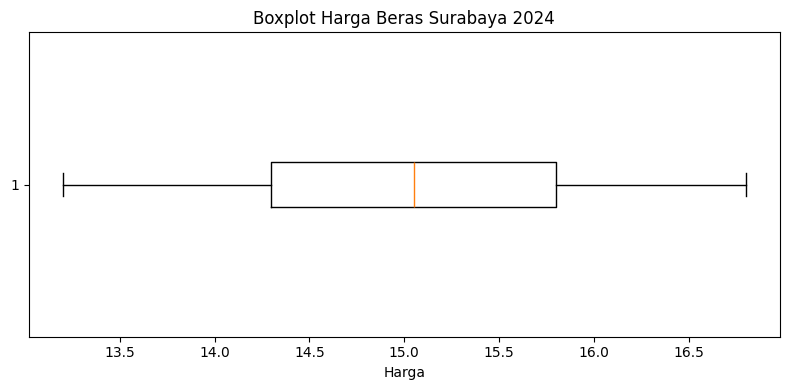

Data setelah feature engineering:


,Komoditas (Rp),Date,Price,day_number,day_of_week,month,price_lag1
0,Beras Kualitas Bawah I,2024-01-01,13.5,0,0,1,14.1
1,Beras Kualitas Bawah II,2024-01-01,13.2,0,0,1,13.5
2,Beras Kualitas Medium I,2024-01-01,13.5,0,0,1,13.2
3,Beras Kualitas Medium II,2024-01-01,14.2,0,0,1,13.5
4,Beras Kualitas Super I,2024-01-01,15.4,0,0,1,14.2


Train shape: (1466, 7) Test shape: (367, 7)
Model saved: rf_beras_surabaya_2024.joblib
MAE: 0.74, MSE: 0.81, RMSE: 0.90


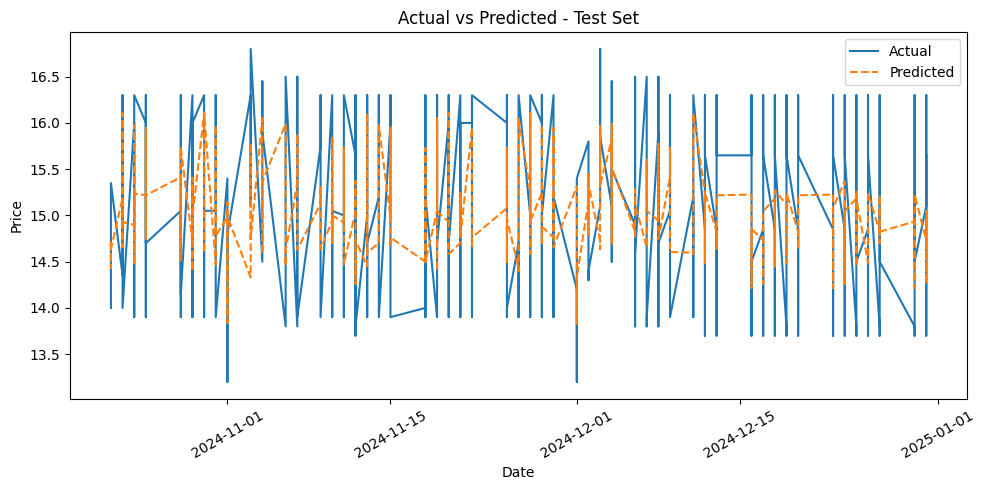

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import gradio as gr

print("pandas:", pd.__version__, "numpy:", np.__version__)

df = pd.read_csv('harga_beras_surabaya_2024.csv', sep=';')
print("Kolom dalam dataset:", df.columns.tolist())
display(df.head())

df.columns = [c.strip() for c in df.columns]

required = ['Komoditas (Rp)', 'date', 'price_num']
for r in required:
    if r not in df.columns:
        raise ValueError(f"Kolom '{r}' tidak ditemukan dalam dataset!")

df_sub = df.copy()

df_sub['Date'] = pd.to_datetime(df_sub['date'], dayfirst=True, errors='coerce')

df_sub['Price'] = pd.to_numeric(df_sub['price_num'], errors='coerce')

df_sub = df_sub[['Komoditas (Rp)', 'Date', 'Price']]
df_sub = df_sub.dropna().sort_values('Date').reset_index(drop=True)

print("Data setelah dibersihkan:")
display(df_sub.head())
print("Shape:", df_sub.shape)

plt.figure(figsize=(8,4))
plt.boxplot(df_sub['Price'], vert=False)
plt.title("Boxplot Harga Beras Surabaya 2024")
plt.xlabel("Harga")
plt.tight_layout()
plt.show()

df_sub['day_number'] = (df_sub['Date'] - df_sub['Date'].min()).dt.days
df_sub['day_of_week'] = df_sub['Date'].dt.dayofweek
df_sub['month'] = df_sub['Date'].dt.month
df_sub['price_lag1'] = df_sub['Price'].shift(1)

df_sub = df_sub.dropna().reset_index(drop=True)

print("Data setelah feature engineering:")
display(df_sub.head())

n = len(df_sub)
split_idx = int(n * 0.8)

train = df_sub.iloc[:split_idx].copy()
test  = df_sub.iloc[split_idx:].copy()

print("Train shape:", train.shape, "Test shape:", test.shape)

features = ['day_number', 'day_of_week', 'month', 'price_lag1']
target = 'Price'

X_train = train[features].values
y_train = train[target].values
X_test  = test[features].values
y_test  = test[target].values

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

joblib.dump(model, 'rf_beras_surabaya_2024.joblib')
print("Model saved: rf_beras_surabaya_2024.joblib")

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

plt.figure(figsize=(10,5))
plt.plot(test['Date'], y_test, label='Actual')
plt.plot(test['Date'], y_pred, label='Predicted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted - Test Set')
plt.legend()
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('SS9_actual_vs_pred.png', dpi=150, bbox_inches='tight')
plt.show()